In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
os.chdir('../')
from eval_helpers import calculate_recall_score, plot_recall_by_k
from candidate_generation import *
os.chdir('../../data/')

In [2]:
transactions = pd.read_pickle('../data/compressed_data/transactions_train.pkl')
customers = pd.read_pickle('../data/compressed_data/customers.pkl')
articles = pd.read_pickle('../data/compressed_data/articles.pkl')

transactions['week'] = 104 - (transactions.t_dat.max() - transactions.t_dat).dt.days // 7

print('First week num: ', transactions.week.min(), '\nLast week num: ', transactions.week.max(), '\n')

# Test week is week after last week in train data
test_week = transactions.week.max()
train_weeks = range(test_week - 10, test_week)

# Filter transactions to last 10 weeks (most recent data)
transactions_train = transactions[transactions.week.isin(train_weeks)]
transaction_test = transactions[transactions.week == test_week]

First week num:  0 
Last week num:  104 



# Run simulation for not interacted with candidates for different k's (10 to 150 with step of 5)

(final running time: 12.92 hours - 836 min)

In [3]:
article_groups_cols = [
    'product_group_name',
    'graphical_appearance_name',
    'colour_group_name',
    'perceived_colour_value_name',
    'perceived_colour_master_name',
    'index_name',
    'index_group_name',
    'section_name',
    'garment_group_name'
]

niw_results = {'k': [], 'col_name': [], 'recall_score': []}

for k in range(10, 151, 5):
    print('k = ', k)
    for col_name in article_groups_cols:
        print('\t', col_name)

        candidates = not_interacted_with_candidates(transactions_train, articles, col_name, k)\
            .groupby('customer_id')['article_id']\
            .apply(lambda x: list(x))\
            .reset_index()

        recall_score = calculate_recall_score(transaction_test, candidates, k=k)

        niw_results['k'].append(k)
        niw_results['col_name'].append(col_name)
        niw_results['recall_score'].append(recall_score)

In [4]:
# niw_results.to_csv('k_sim_results/not_interacted_with_sim.csv', index=False)

In [5]:
niw_results = pd.read_csv('k_sim_results/not_interacted_with_sim.csv')
niw_results.sample(5)

,k,col_name,recall_score
180,110,product_group_name,0.031931
73,50,graphical_appearance_name,0.023189
239,140,index_name,0.038700
225,135,product_group_name,0.036455
211,125,perceived_colour_master_name,0.046244


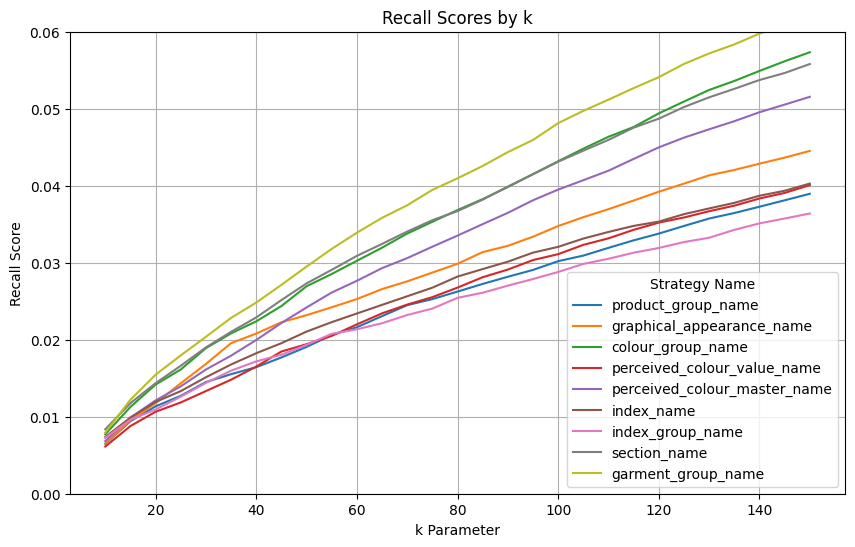

In [6]:
plot_recall_by_k(niw_results, legend_column='col_name')

# Run simulation for seasonal candidates

In [7]:
seasonal_results = {'k': [], 'months': [], 'seasonal_baskets_score': [], 'seasonal_bestsellers_score': []}

for k in tqdm(range(10, 151, 5)):
        for months in [[9], [10], [8], [9, 8], [9, 10], [10, 9, 8]]:

            # Calculate and evaluate recall score for seasonal baskets
            seasonal_baskets = generate_seasonal_baskets(transactions, [2019], months, k, include_rank=False)

            candidates = seasonal_baskets\
                .drop(columns=['year'])\
                .groupby('customer_id')['article_id']\
                .apply(lambda x: list(x))\
                .reset_index()
            
            seasonal_baskets_score = calculate_recall_score(transaction_test, candidates, k=k)

            # Calculate end evaluate recall score for seasonal bestsellers
            seasonal_bestsellers = generate_seasonal_bestsellers(transactions, [2019], months, k, include_rank=False)

            candidates = pd.DataFrame(
                transaction_test.customer_id.unique(),
                columns=['customer_id']
                )
            candidates['year'] = 2019
            candidates = pd.merge(candidates, seasonal_bestsellers, on='year')\
                .groupby('customer_id')['article_id']\
                .apply(lambda x: list(x))\
                .reset_index()
            
            seasonal_bestsellers_score = calculate_recall_score(transaction_test, candidates, k=k)

            # Save results
            months = '_'.join([str(month) for month in months])
            seasonal_results['k'].append(k)
            seasonal_results['months'].append(months)
            seasonal_results['seasonal_baskets_score'].append(seasonal_baskets_score)
            seasonal_results['seasonal_bestsellers_score'].append(seasonal_bestsellers_score)

In [8]:
seasonal_results = pd.DataFrame(seasonal_results)

seasonal_results_formatted = pd.melt(
    seasonal_results, 
    id_vars=['k', 'months'], 
    value_vars=['seasonal_baskets_score', 'seasonal_bestsellers_score'], 
    var_name='col_name', 
    value_name='recall_score'
    )

seasonal_results_formatted.to_csv('k_sim_results/seasonal_sim.csv', index=False)

In [9]:
seasonal_results_formatted = pd.read_csv('k_sim_results/seasonal_sim.csv')
seasonal_results_formatted['col_name'] = seasonal_results_formatted['col_name'] + '_' + seasonal_results_formatted['months']
seasonal_results_formatted.drop(columns=['months'], inplace=True)
seasonal_results_formatted

,k,col_name,recall_score
0,10,seasonal_baskets_score_9,0.003139
1,10,seasonal_baskets_score_10,0.002774
2,10,seasonal_baskets_score_8,0.002177
3,10,seasonal_baskets_score_9_8,0.003575
4,10,seasonal_baskets_score_9_10,0.003844
...,...,...,...
343,150,seasonal_bestsellers_score_10,0.031405
344,150,seasonal_bestsellers_score_8,0.029698
345,150,seasonal_bestsellers_score_9_8,0.036547
346,150,seasonal_bestsellers_score_9_10,0.035225


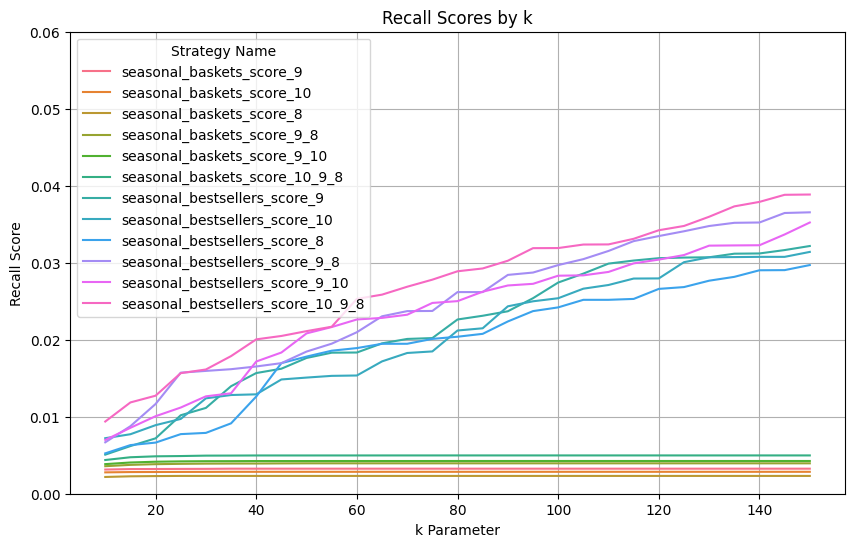

In [10]:
plot_recall_by_k(seasonal_results_formatted, legend_column='col_name')

# Run simulation for similar not bought

In [11]:
sims = generate_item_similarities(transactions_train, articles)

sim_candidates = generate_sim_not_bought_candidates(transactions_train, sims, 150, include_score=True)

In [12]:
sim_results = {'k': [], 'strategy_name': [], 'recall_score': []}

candidates_grouped = sim_candidates\
    .sort_values(by=['customer_id', 'similarity_score'], ascending=False)\
    .groupby('customer_id')

for k in tqdm(range(10, 151, 5)):

    candidates = candidates_grouped\
        .head(k)\
        .reset_index(drop=True)\
        .groupby('customer_id')['article_id']\
        .apply(lambda x: list(x))\
        .reset_index()

    recall_score = calculate_recall_score(transaction_test, candidates, k=k)

    sim_results['k'].append(k)
    sim_results['strategy_name'].append('similar_not_bought')
    sim_results['recall_score'].append(recall_score)

In [13]:
sim_results.to_csv('k_sim_results/similar_not_bought_sim.csv', index=False)

In [14]:
sim_results = pd.read_csv('k_sim_results/similar_not_bought_sim.csv')
sim_results.sample(5)

,k,strategy_name,recall_score
0,10,similar_not_bought,0.003866
13,75,similar_not_bought,0.014594
26,140,similar_not_bought,0.022823
19,105,similar_not_bought,0.018668
6,40,similar_not_bought,0.009579


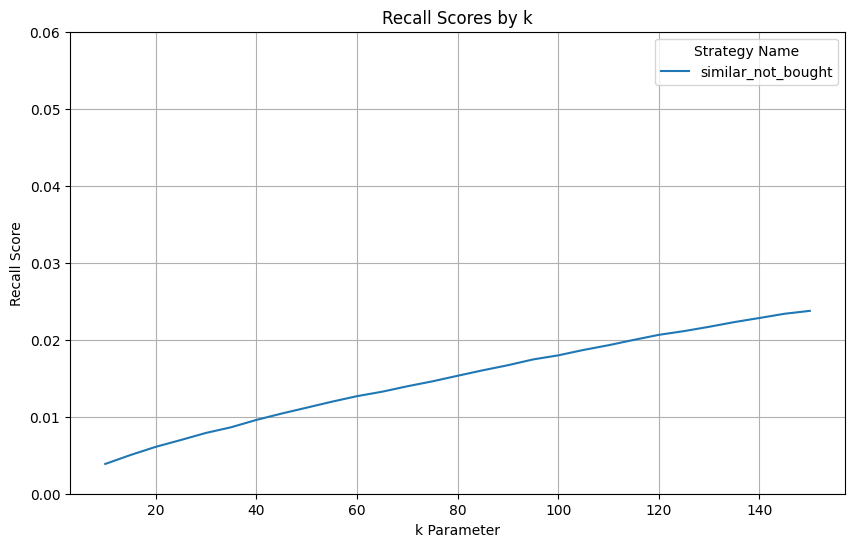

In [15]:
plot_recall_by_k(sim_results, 'strategy_name')

# Plot all results together

For not interacted with candidates, group by articles group and get mean for given k.
For seasonal candidates, group by seasonal baskets and seasonal bestsellers.

In [16]:
niw_plot = niw_results\
    .groupby('k')['recall_score'].mean()\
    .reset_index()
niw_plot['strategy_name'] = 'not_interacted_with_average'
niw_plot.sample(5)

,k,recall_score,strategy_name
14,80,0.031617,not_interacted_with_average
7,45,0.021648,not_interacted_with_average
19,105,0.037994,not_interacted_with_average
9,55,0.024879,not_interacted_with_average
28,150,0.047448,not_interacted_with_average


In [17]:
seasonal_results_formatted['group'] = seasonal_results_formatted['col_name']\
    .apply(lambda x: 'seasonal_baskets_average' if 'baskets' in x else 'seasonal_bestsellers_average')
seasonal_plot = seasonal_results_formatted\
    .drop(columns=['col_name'])\
    .rename(columns={'group': 'strategy_name'})\
    .groupby(['k', 'strategy_name'])['recall_score'].mean()\
    .reset_index()
seasonal_plot.sample(5)

,k,strategy_name,recall_score
16,50,seasonal_baskets_average,0.003595
47,125,seasonal_bestsellers_average,0.031239
53,140,seasonal_bestsellers_average,0.032730
43,115,seasonal_bestsellers_average,0.029892
50,135,seasonal_baskets_average,0.003597


In [18]:
all_plot = pd.concat([niw_plot, seasonal_plot, sim_results], axis=0)
all_plot.sample(10)

,k,recall_score,strategy_name
25,135,0.044541,not_interacted_with_average
39,105,0.028597,seasonal_bestsellers_average
8,30,0.003576,seasonal_baskets_average
28,150,0.023748,similar_not_bought
29,80,0.024050,seasonal_bestsellers_average
12,70,0.013950,similar_not_bought
6,40,0.019915,not_interacted_with_average
27,145,0.023373,similar_not_bought
0,10,0.003315,seasonal_baskets_average
32,90,0.003597,seasonal_baskets_average


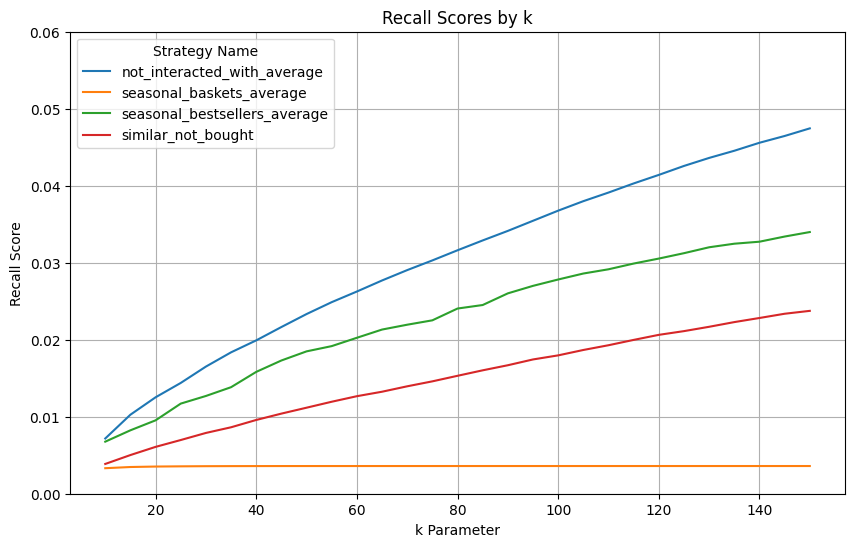

In [19]:
plot_recall_by_k(all_plot, 'strategy_name')